In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
from simulation import simulate_emission_quadratic, simulate_log_damage

np.random.seed(0)

In [2]:
# Model parameters
δ = 0.01
η = 0.032
median = 1.75/1000
h_hat = 0.2
σ_n = 1.5
γ_low = 0.012
γ_high = 0.024
# ξ = σ_n/h_hat*δ*η
ξ = 8*δ*η

# Simulation setting
# r_start = 1500
r_start = 1000
T = 500

In [3]:
# Table for e_tilde
def e_tilde_fun(ξ, γ, median=1.75/1000, σ_n=1.5, δ=0.01, η=0.032):
    τ_1 = γ*median
    τ_2 = (τ_1**2) * (σ_n**2) / (2*ξ)
    if τ_2 == 0:
        res = δ*η/τ_1
    else:
        res = (-τ_1 + np.sqrt(τ_1**2 + 4*δ*η*τ_2)) / (2*τ_2)
    return res

In [4]:
e_tilde_low_0 = e_tilde_fun(ξ, γ_low, σ_n=0)
e_tilde_low = e_tilde_fun(ξ, γ_low)
e_tilde_low_01x = e_tilde_fun(ξ*0.1, γ_low)
e_tilde_low_05x = e_tilde_fun(ξ*0.5, γ_low)
e_tilde_low_5x = e_tilde_fun(ξ*5, γ_low)
e_tilde_low_10x = e_tilde_fun(ξ*10, γ_low)

e_tilde_high_0 = e_tilde_fun(ξ, γ_high, σ_n=0)
e_tilde_high = e_tilde_fun(ξ, γ_high)
e_tilde_high_01x = e_tilde_fun(ξ*0.1, γ_high)
e_tilde_high_05x = e_tilde_fun(ξ*0.5, γ_high)
e_tilde_high_5x = e_tilde_fun(ξ*5, γ_high)
e_tilde_high_10x = e_tilde_fun(ξ*10, γ_high)

In [5]:
import pandas as pd
df = pd.DataFrame([[e_tilde_low_01x, e_tilde_low_05x, e_tilde_low, e_tilde_low_5x, e_tilde_low_10x, e_tilde_low_0],
                   [e_tilde_high_01x, e_tilde_high_05x, e_tilde_high, e_tilde_high_5x, e_tilde_high_10x, e_tilde_high_0]])
df.index = ['γ = 0.012', 'γ = 0.024']
df.columns = ['0.1x ξ', '0.5x ξ', '1x ξ', '5x ξ', '10x ξ', 'τ_2 = 0']
df

,0.1x ξ,0.5x ξ,1x ξ,5x ξ,10x ξ,τ_2 = 0
γ = 0.012,8.359372,12.272754,13.4558,14.806482,15.016134,15.238095
γ = 0.024,4.179686,6.136377,6.7279,7.403241,7.508067,7.619048


## 1. Emission trajectory

In [6]:
# Simulate emission trajectory
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_low, r_grid_low, _, e_grid_low  = simulate_emission_quadratic(δ, η, median*γ_low, ξ, σ_n, # Replace σ_n with 0 if you want to set τ_2 = 0.
                                     args_trace_ϕ=args_trace_ϕ,
                                     r_start=r_start, T=T)
Et_high, r_grid_high, _, e_grid_high = simulate_emission_quadratic(δ, η, median*γ_high, ξ, σ_n,
                                      args_trace_ϕ=args_trace_ϕ,
                                      r_start=r_start, T=T)

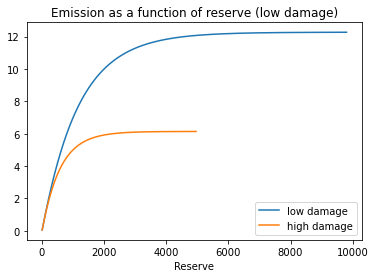

In [7]:
plt.plot(r_grid_low, e_grid_low, label='low damage')
plt.plot(r_grid_high, e_grid_high, label='high damage')
plt.legend()
plt.xlabel('Reserve')
plt.title('Emission as a function of reserve (low damage)')
plt.show()

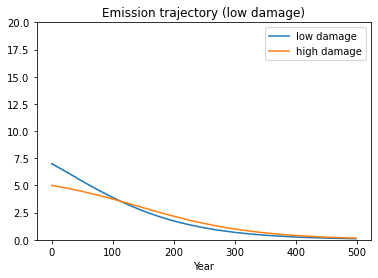

In [8]:
plt.plot(Et_low, label='low damage')
plt.plot(Et_high, label='high damage')
plt.legend()
plt.xlabel('Year')
plt.ylim(0,20)
plt.title('Emission trajectory (low damage)')
plt.show()

## 2. Implied $\hat{h}$

In [9]:
E_tilde_low = δ*η/(median*γ_low)
E_tilde_high = δ*η/(median*γ_high)
h_hat_implied_low = Et_low/E_tilde_low * h_hat
h_hat_implied_high = Et_high/E_tilde_high * h_hat

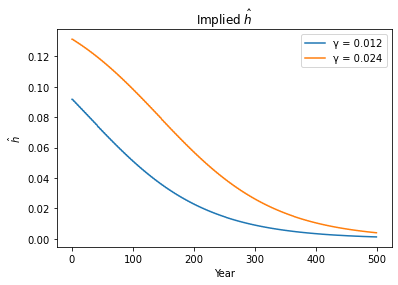

In [10]:
plt.plot(h_hat_implied_low, label='γ = 0.012')
plt.plot(h_hat_implied_high, label='γ = 0.024')
plt.xlabel('Year')
plt.ylabel(r'$\hat{h}$')
plt.title(r'Implied $\hat{h}$')
plt.legend()
plt.show()

## 3. Damage and temperature change

In [11]:
T_plots = 100
# Simulate damages
exp_avg_response_low = median * γ_low / (1-η)
exp_avg_response_high = median * γ_high / (1-η)
Ws = np.random.normal(0., 1., (100_000, T))
log_damage_low = simulate_log_damage(exp_avg_response_low, σ_n, Et_low, Ws)
log_damage_high = simulate_log_damage(exp_avg_response_high, σ_n, Et_high, Ws)
proportional_damage_low = np.exp(-log_damage_low)
proportional_damage_high = np.exp(-log_damage_high)

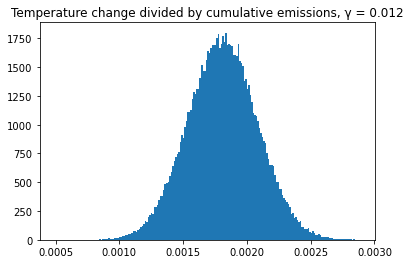

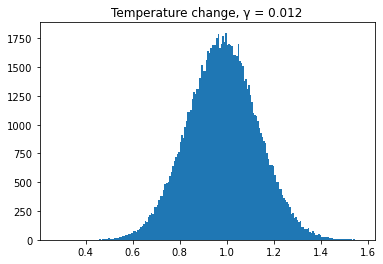

In [12]:
# Histogram for temperature change divided by cumulative emissions
plt.hist(log_damage_low[:, T_plots-1] / Et_low[:T_plots].sum() / γ_low, bins=200)
plt.title('Temperature change divided by cumulative emissions, γ = 0.012')
plt.show()
# Histogram for temperature change
plt.hist(log_damage_low[:, T_plots-1] / γ_low, bins=200)
plt.title('Temperature change, γ = 0.012')
plt.show()

In [13]:
np.std(log_damage_low[:, T_plots-1] / Et_low[:T_plots].sum() / γ_low)

0.0002741178173507894

In [ ]:
# Histogram for temperature change divided by cumulative emissions
plt.hist(log_damage_high[:, T_plots-1] / Et_high[:T_plots].sum() / γ_high, bins=200)
plt.title('Temperature change divided by cumulative emissions, γ = 0.024')
plt.show()
# Histogram for temperature change
plt.hist(log_damage_high[:, T_plots-1] / γ_high, bins=200)
plt.title('Temperature change, γ = 0.024')
plt.show()

## 4. Compare $\xi$

In [ ]:
# # Simulate emission trajectory, 0.0001x ξ
# args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
# Et_low_00001x, r_grid_low_00001x, _, e_grid_low_00001x  = simulate_emission_quadratic(δ, η, median*γ_low, ξ*0.0001, σ_n,
#                                                          args_trace_ϕ=args_trace_ϕ,
#                                                          r_start=r_start, T=T)
# args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
# Et_high_00001x, r_grid_high_00001x, _, e_grid_high_00001x = simulate_emission_quadratic(δ, η, median*γ_high, ξ*0.0001, σ_n,
#                                                            args_trace_ϕ=args_trace_ϕ,
#                                                            r_start=r_start, T=T)

# Simulate emission trajectory, 0.001x ξ
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_low_0001x, r_grid_low_0001x, _, e_grid_low_0001x  = simulate_emission_quadratic(δ, η, median*γ_low, ξ*0.001, σ_n,
                                                         args_trace_ϕ=args_trace_ϕ,
                                                         r_start=r_start, T=T)
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_high_0001x, r_grid_high_0001x, _, e_grid_high_0001x = simulate_emission_quadratic(δ, η, median*γ_high, ξ*0.001, σ_n,
                                                           args_trace_ϕ=args_trace_ϕ,
                                                           r_start=r_start, T=T)

# Simulate emission trajectory, 0.01x ξ
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_low_001x, r_grid_low_001x, _, e_grid_low_001x  = simulate_emission_quadratic(δ, η, median*γ_low, ξ*0.01, σ_n,
                                                         args_trace_ϕ=args_trace_ϕ,
                                                         r_start=r_start, T=T)
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_high_001x, r_grid_high_001x, _, e_grid_high_001x = simulate_emission_quadratic(δ, η, median*γ_high, ξ*0.01, σ_n,
                                                           args_trace_ϕ=args_trace_ϕ,
                                                           r_start=r_start, T=T)

# Simulate emission trajectory, 0.1x ξ
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_low_01x, r_grid_low_01x, _, e_grid_low_01x = simulate_emission_quadratic(δ, η, median*γ_low, ξ*0.1, σ_n,
                                     args_trace_ϕ=args_trace_ϕ,
                                     r_start=r_start, T=T)
Et_high_01x, r_grid_high_01x, _, e_grid_high_01x  = simulate_emission_quadratic(δ, η, median*γ_high, ξ*0.1, σ_n,
                                      args_trace_ϕ=args_trace_ϕ,
                                      r_start=r_start, T=T)

# Simulate emission trajectory, 1x ξ
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_low, r_grid_low, _, e_grid_low = simulate_emission_quadratic(δ, η, median*γ_low, ξ, σ_n,
                                     args_trace_ϕ=args_trace_ϕ,
                                     r_start=r_start, T=T)
Et_high, r_grid_high, _, e_grid_high  = simulate_emission_quadratic(δ, η, median*γ_high, ξ, σ_n,
                                      args_trace_ϕ=args_trace_ϕ,
                                      r_start=r_start, T=T)

# Simulate emission trajectory, 10x ξ
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_low_10x, r_grid_low_10x, _, e_grid_low_10x = simulate_emission_quadratic(δ, η, median*γ_low, ξ*10, σ_n,
                                     args_trace_ϕ=args_trace_ϕ,
                                     r_start=r_start, T=T)
Et_high_10x, r_grid_high_10x, _, e_grid_high_10x  = simulate_emission_quadratic(δ, η, median*γ_high, ξ*10, σ_n,
                                      args_trace_ϕ=args_trace_ϕ,
                                      r_start=r_start, T=T)

# Simulate emission trajectory, 100x ξ
args_trace_ϕ = (-20, -5, 1000, 1e-9, 1e-3)
Et_low_100x, r_grid_low_100x, _, e_grid_low_100x = simulate_emission_quadratic(δ, η, median*γ_low, ξ*100, σ_n,
                                     args_trace_ϕ=args_trace_ϕ,
                                     r_start=r_start, T=T)
Et_high_100x, r_grid_high_100x, _, e_grid_high_100x  = simulate_emission_quadratic(δ, η, median*γ_high, ξ*100, σ_n,
                                      args_trace_ϕ=args_trace_ϕ,
                                      r_start=r_start, T=T)

In [ ]:
h_hat_implied_low_0001x = Et_low_0001x*(median*γ_low)*σ_n/(ξ*0.001)
h_hat_implied_low_001x = Et_low_001x*(median*γ_low)*σ_n/(ξ*0.01)
h_hat_implied_low_01x = Et_low_01x*(median*γ_low)*σ_n/(ξ*0.1)
h_hat_implied_low = Et_low*(median*γ_low)*σ_n/ξ
h_hat_implied_low_10x = Et_low_10x*(median*γ_low)*σ_n/(ξ*10)
h_hat_implied_low_100x = Et_low_100x*(median*γ_low)*σ_n/(ξ*100)

h_hat_implied_high_0001x = Et_high_0001x*(median*γ_high)*σ_n/(ξ*0.001)
h_hat_implied_high_001x = Et_high_001x*(median*γ_high)*σ_n/(ξ*0.01)
h_hat_implied_high_01x = Et_high_01x*(median*γ_high)*σ_n/(ξ*0.1)
h_hat_implied_high = Et_high*(median*γ_high)*σ_n/ξ
h_hat_implied_high_10x = Et_high_10x*(median*γ_high)*σ_n/(ξ*10)
h_hat_implied_high_100x = Et_high_100x*(median*γ_high)*σ_n/(ξ*100)

In [ ]:
plt.plot(r_grid_low_100x, e_grid_low_100x, label='100x ξ')
plt.plot(r_grid_low_10x, e_grid_low_10x, label='10x ξ')
plt.plot(r_grid_low, e_grid_low, label='1x ξ')
plt.plot(r_grid_low_01x, e_grid_low_01x, label='0.1x ξ')
plt.plot(r_grid_low_001x, e_grid_low_001x, label='0.01x ξ')
plt.plot(r_grid_low_0001x, e_grid_low_0001x, label='0.001x ξ')
# plt.plot(r_grid_low_00001x, e_grid_low_00001x, label='1e-4x ξ')

plt.legend()
plt.xlabel('Reserve')
plt.title('Figure 1: Emission as a function of reserve (low damage)')
plt.savefig('figure_1.pdf')
plt.show()

In [ ]:
plt.plot(Et_low_100x, label='100x ξ')
plt.plot(Et_low_10x, label='10x ξ')
plt.plot(Et_low, label='1x ξ')
plt.plot(Et_low_01x, label='0.1x ξ')
plt.plot(Et_low_001x, label='0.01x ξ')
plt.plot(Et_low_0001x, label='0.001x ξ')
# plt.plot(Et_low_00001x, label='1e-4x ξ')
plt.legend()
plt.xlabel('Year')
# plt.ylim(0,20)
plt.title('Figure 2: Emission trajectory (low damage)')
plt.savefig('figure_2.pdf')
plt.show()

In [ ]:
plt.plot(h_hat_implied_low_100x, label='100x ξ')
plt.plot(h_hat_implied_low_10x, label='10x ξ')
plt.plot(h_hat_implied_low, label='1x ξ')
plt.plot(h_hat_implied_low_01x, label='0.1x ξ')
plt.plot(h_hat_implied_low_001x, label='0.01x ξ')
plt.plot(h_hat_implied_low_0001x, label='0.001x ξ')
# plt.plot(h_hat_implied_low_00001x, label='1e-4x ξ')
plt.legend()
plt.xlabel('Year')
# plt.ylim(0,0.3)
plt.title(r'Figure 3: Implied $\hat{h}$ (low damage)')
plt.savefig('figure_3.pdf')
plt.show()

In [ ]:
plt.plot(r_grid_high_100x, e_grid_high_100x, label='100x ξ')
plt.plot(r_grid_high_10x, e_grid_high_10x, label='10x ξ')
plt.plot(r_grid_high, e_grid_high, label='1x ξ')
plt.plot(r_grid_high_01x, e_grid_high_01x, label='0.1x ξ')
plt.plot(r_grid_high_001x, e_grid_high_001x, label='0.01x ξ')
plt.plot(r_grid_high_0001x, e_grid_high_0001x, label='0.001x ξ')
# plt.plot(r_grid_high_00001x, e_grid_high_001x, label='1e-4x ξ')
plt.legend()
plt.xlabel('Reserve')
plt.title('Figure 4: Emission as a function of reserve (high damage)')
plt.savefig('figure_4.pdf')
plt.show()

In [ ]:
plt.plot(Et_high_100x, label='100x ξ')
plt.plot(Et_high_10x, label='10x ξ')
plt.plot(Et_high, label='1x ξ')
plt.plot(Et_high_01x, label='0.1x ξ')
plt.plot(Et_high_001x, label='0.01x ξ')
plt.plot(Et_high_0001x, label='0.001x ξ')
# plt.plot(Et_high_00001x, label='1e-4x ξ')
plt.legend()
plt.xlabel('Year')
# plt.ylim(0,9)
plt.title('Figure 5: Emission trajectory (high damage)')
plt.savefig('figure_5.pdf')
plt.show()

In [ ]:
plt.plot(h_hat_implied_high_100x, label='100x ξ')
plt.plot(h_hat_implied_high_10x, label='10x ξ')
plt.plot(h_hat_implied_high, label='1x ξ')
plt.plot(h_hat_implied_high_01x, label='0.1x ξ')
plt.plot(h_hat_implied_high_001x, label='0.01x ξ')
plt.plot(h_hat_implied_high_0001x, label='0.001x ξ')
# plt.plot(h_hat_implied_high_00001x, label='1e-4x ξ')
plt.legend()
plt.xlabel('Year')
# plt.ylim(0,0.3)
plt.title(r'Figure 6: Implied $\hat{h}$ (high damage)')
plt.savefig('figure_6.pdf')
plt.show()